기존 교사 강요 이용한 모델  
구글 코랩에서 학습

In [1]:
!git clone https://github.com/Upota/Transformer_Auto-Encoder.git
%cd /content/Transformer_Auto-Encoder/Prediction/TeacherForcing_ver.1/

Cloning into 'Transformer_Auto-Encoder'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 50 (delta 19), reused 39 (delta 10), pack-reused 0
Unpacking objects: 100% (50/50), done.
/content/Transformer_Auto-Encoder/Prediction/TeacherForcing_ver.1


In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [3]:
# make deterministic
from utils import set_seed
set_seed(42)

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Denoising Signal

1. $$ sin(t) + \epsilon $$
2. $$ \sum^{n}{a sin(bt + c)} + \epsilon $$

## Data generation

### Data 1

In [5]:
# set parameters
block_size = 128

n_in = 1
n_sample = 51200
n_valid = 256

In [23]:
# generate sequential sine signal
x_interval = 0.09
sin_x = np.linspace(0, x_interval * n_sample, num=n_sample)
pure_sin = np.sin(sin_x)
noisy_sin = pure_sin + 0.1 * np.random.randn(pure_sin.shape[0])

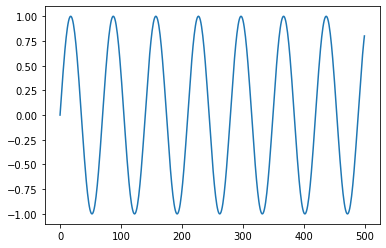

In [24]:
pure = pure_sin[0:500]
plt.plot(range(len(pure)), pure)

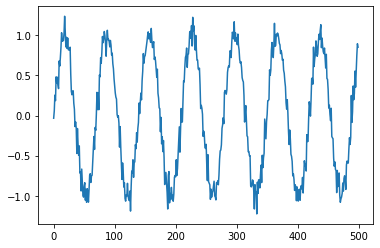

In [25]:
noisy = noisy_sin[0:500]
plt.plot(range(len(noisy)), noisy)

In [9]:
class SinDataset(Dataset): # build custom dataset
    
    def __init__(self, x, y, block_size):
        self.block_size = block_size
        self.x = x # noisy_sin
        self.y = y # pure_sin
    
    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) elements from the data
        noisy_chunk = self.x[idx:idx + self.block_size + 1]
        pure_chunk = self.y[idx:idx + self.block_size + 1]
    
        x = torch.tensor(noisy_chunk[:-1], dtype=torch.float)
        y = torch.tensor(pure_chunk[1:], dtype=torch.float)
        return x, y
    
    def __len__(self):
        return len(self.x) - self.block_size

In [10]:
train_dataset1 = SinDataset(noisy_sin, pure_sin, block_size)
start_idx = 150
valid_dataset1 = SinDataset(noisy_sin[start_idx:start_idx + n_valid],
                            pure_sin[start_idx:start_idx + n_valid], block_size)

### Data 2

In [11]:
# generate sequential complex sine signal
x_interval = 0.2
sin_x = np.linspace(0, x_interval * n_sample, num=n_sample)
sin_1 = np.sin(sin_x) # sin(t)
sin_2 = 1.5 * np.sin(0.5 * sin_x + 0.3 * np.pi) # 1.5sin(t + 0.3pi)
pure_sin = sin_1 + sin_2
noisy_sin = pure_sin + 0.1 * np.random.randn(pure_sin.shape[0])

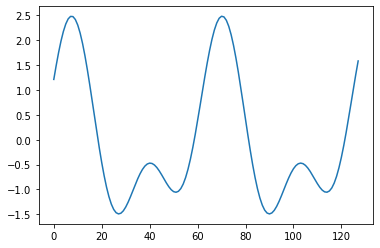

In [12]:
pure = pure_sin[0:128]
plt.plot(range(len(pure)), pure)

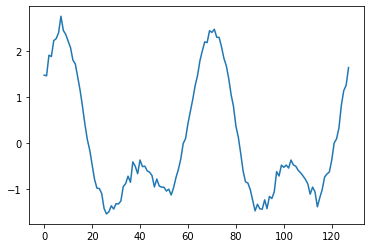

In [13]:
noisy = noisy_sin[0:128]
plt.plot(range(len(noisy)), noisy)

In [14]:
train_dataset2 = SinDataset(noisy_sin, pure_sin, block_size)

## Model

In [15]:
from model import TAE, TAEConfig
mconf = TAEConfig(n_in, block_size,
                 n_layer=2, n_head=4, n_embd=128)
model = TAE(mconf)

08/02/2021 11:23:24 - INFO - model - number of parameters: 9.265920e+05


In [16]:
import gc
gc.collect()

255

In [17]:
from pathlib import Path

PATH = Path("model")
FILENAME = "predict_data1" + ".ckpt"
ckpt_path = PATH / FILENAME
# ckpt_path = None
if ckpt_path is not None and ckpt_path.exists():
    print("load")
    model.load_state_dict(torch.load(ckpt_path))

## Training

In [18]:
from trainer import Trainer, TrainerConfig
tconf = TrainerConfig(max_epochs=51, batch_size=256, learning_rate=6e-4,
                     lr_decay = True, ckpt_path=ckpt_path,
                     num_workers=2)
trainer = Trainer(model, train_dataset1, valid_dataset1, tconf)
trainer.train()

epoch 1 iter 199: train loss 0.00973. lr 6.000000e-04: 100%|██████████| 200/200 [00:35<00:00,  5.60it/s]
08/02/2021 11:24:18 - INFO - trainer - test loss: 0.009011
08/02/2021 11:24:18 - INFO - trainer - saving model/predict_data1.ckpt
epoch 2 iter 199: train loss 0.00708. lr 5.994310e-04: 100%|██████████| 200/200 [00:36<00:00,  5.51it/s]
08/02/2021 11:24:55 - INFO - trainer - test loss: 0.005701
08/02/2021 11:24:55 - INFO - trainer - saving model/predict_data1.ckpt
epoch 3 iter 199: train loss 0.00584. lr 5.977262e-04: 100%|██████████| 200/200 [00:36<00:00,  5.47it/s]
08/02/2021 11:25:32 - INFO - trainer - test loss: 0.005084
08/02/2021 11:25:32 - INFO - trainer - saving model/predict_data1.ckpt
epoch 4 iter 199: train loss 0.00507. lr 5.948919e-04: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
08/02/2021 11:26:09 - INFO - trainer - test loss: 0.004212
08/02/2021 11:26:09 - INFO - trainer - saving model/predict_data1.ckpt
epoch 5 iter 199: train loss 0.00424. lr 5.909391e-04: 100%|

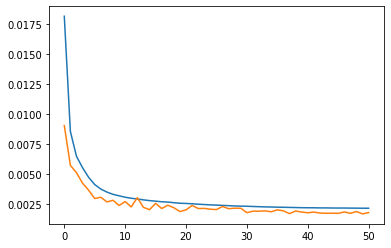

In [20]:
plt.plot(range(len(trainer.train_losses)), trainer.train_losses, label="Training loss")
plt.plot(range(len(trainer.validation_losses)), trainer.validation_losses, label="Validation loss")

## Testing

In [65]:
from utils import sample
start_idx = 500
x = torch.tensor(noisy_sin[start_idx : start_idx + block_size], dtype=torch.float).to(trainer.device).view(1, block_size)
y = sample(model, x, block_size * 2)[0]
y = y.cpu().numpy()

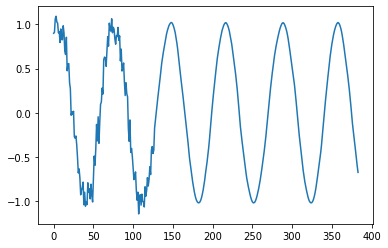

In [66]:
plt.plot(range(len(y)), y)

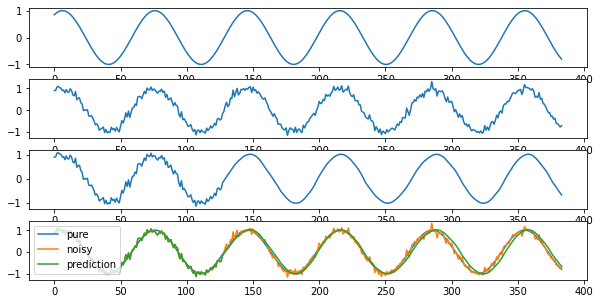

In [67]:
pure = pure_sin[start_idx : start_idx + 3 * block_size]
noisy = noisy_sin[start_idx : start_idx + 3 * block_size]

plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(range(0, 3 * block_size), pure, label='pure')

plt.subplot(412)
plt.plot(range(0, 3 * block_size), noisy, label='noisy')

plt.subplot(413)
plt.plot(range(len(y)), y, label='prediction')

plt.subplot(414)
plt.plot(range(3 * block_size), pure, label='pure')
plt.plot(range(3 * block_size), noisy, label='noisy')
plt.plot(range(len(y)), y, label='prediction')
plt.legend()
plt.show()

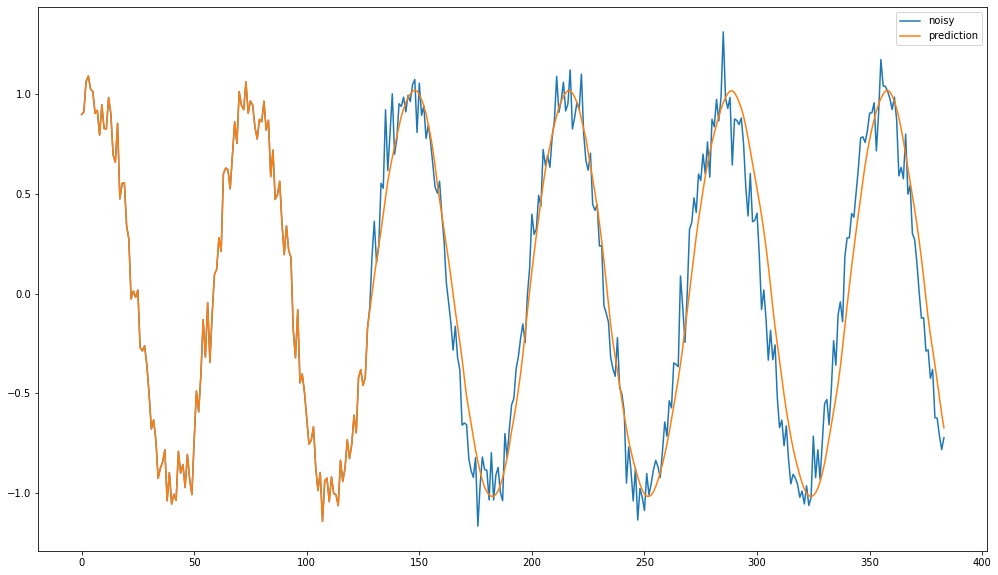

In [68]:
plt.figure(figsize=(17,10))
plt.plot(range(3 * block_size), noisy, label='noisy')
# plt.plot(range(block_size, len(y)), y[block_size:], label='prediction')
plt.plot(range(len(y)), y, label='prediction')
plt.legend()
plt.show()

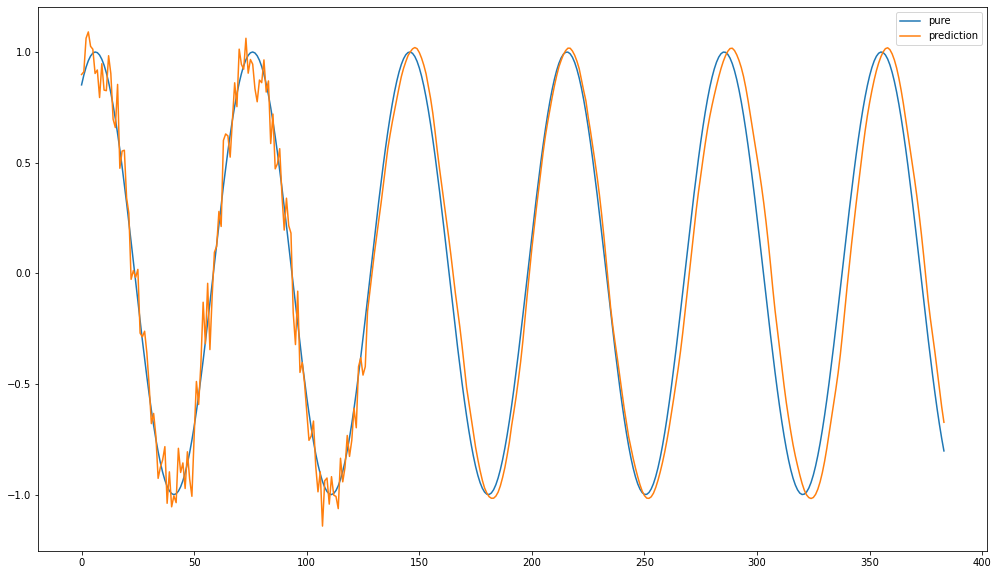

In [69]:
plt.figure(figsize=(17,10))
plt.plot(range(3 * block_size), pure, label='pure')
# plt.plot(range(block_size, len(y)), y[block_size:], label='prediction')
plt.plot(range(len(y)), y, label='prediction')
plt.legend()
plt.show()